<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/EQNN_p4m_mnist_no_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# p4m EQNN

In this notebook, we build the invariant Equivariant Quantum Neural Network under the p4m symmetry, consisting of the reflections over the X and Y axis, and the rotatations by 90 degrees.

We test the invariance of this model using the MNIST dataset and local transformations to perform reflections and rotations over the data.

The main reference is:

Approximately Equivariant Quantum Neural Network for $p4m$ Group Symmetries in Images. https://arxiv.org/abs/2310.02323.

# dataset

## MNIST

In [2]:
%%capture
pip install pennylane jax jaxlib

In [4]:
import pennylane as qml
import jax
from jax import numpy as jnp
import optax
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [5]:
def preprocess_jnp(
    classes: jnp.ndarray, trainloader: DataLoader, testloader: DataLoader
):
    r"""Load Data from PyTorch DataLoader into JAX NumPy Arrays

    Args:
        classes (jnp.ndarray) : List of integers representing data classes to be loaded.
            If None, return all classes.
        trainloader (torch.utils.data.DataLoader) : Trainset loader.
        testloader (torch.utils.data.DataLoader) : Testset loader.

    Returns:
        Tuple[jnp.ndarray, ...]: Tuple of training and test data/labels. The outputs are
        ordered as follows:

        * ``X_train``: Training samples of shape ``(num_train, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Training labels of shape ``(num_train, )``.
        * ``X_test``: Test samples of shape ``(num_test, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Test labels of shape ``(num_test, )``.
    """
    X_train = []
    Y_train = []

    X_test = []
    Y_test = []

    print(classes)
    # Load data as a np.ndarray
    for i, data in enumerate(trainloader, 0):
        image, label = data
        X_train.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_train.extend(list(label.detach().numpy()))

    for i, data in enumerate(testloader, 0):
        image, label = data
        X_test.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_test.extend(list(label.detach().numpy()))

    X_train = jnp.array(X_train)
    Y_train = jnp.array(Y_train)

    X_test = jnp.array(X_test)
    Y_test = jnp.array(Y_test)

    if classes is not None:
        train_mask = np.isin(Y_train, classes)
        X_train = X_train[train_mask]
        Y_train = Y_train[train_mask]

        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[0])].set(0.0)
        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[1])].set(1.0)

        test_mask = np.isin(Y_test, classes)
        X_test = X_test[test_mask]
        Y_test = Y_test[test_mask]
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[0])].set(0.0)
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[1])].set(1.0)

    return X_train, Y_train, X_test, Y_test


import torch
import torchvision
import torchvision.datasets as datasets

load_dir = "/content/dataset"
img_size = 16
classes = [0, 1]


# Here we perform the symmetry operations to the data: Flip over X and Y axis and rotations per 90 degrees.
transform = transforms.Compose(
                [
                    transforms.Resize([img_size, img_size]),
                    transforms.ToTensor(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90),
                ]
            )

train_ds = datasets.MNIST(root=load_dir, train=True, download=True, transform=transform)

test_ds = datasets.MNIST(root=load_dir, train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(
            train_ds, batch_size=1024, shuffle=True
        )

testloader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=True)

X_train, Y_train, X_test, Y_test = preprocess_jnp(
            classes, trainloader, testloader
        )

[0, 1]


/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible

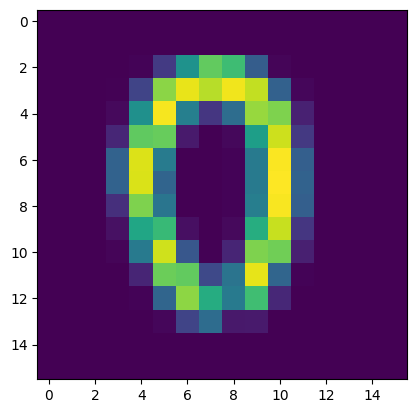

In [67]:
import matplotlib.pyplot as plt
plt.imshow(X_train[6])

# model

## embed image
Convert an image of dimension $(2^{(n/2)}, 2^{(n/2)})$ into an jnp array of dimension $2^{2n}$ with each corresponding value of the pixel mapped using the sin function.

pixel values : values from [0,1]

features values : values from [-1, 1]



$$img[i,j] ---> \sin(img[i,j]) \, |i,j⟩$$


In [10]:
from typing import List
import jax.numpy as jnp

# Function to embed an image into a quantum state
def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
    # n = 8
    n = len(wires) // 2

    # If the image is single-channel, reshape it to 2D
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Initialize the feature vector with zeros
    features = jnp.zeros(2 ** (2*n)) # 2^(2*4) = 2^8 = 256 = 16x16

    # for each pixel in the image, we asign a value using the sine function with the
    # value of the pixel as an argument.

    # Then, Fill the feature vector with sine-transformed pixel values
    for i in range(2**n): # iterate in the width size (16 pixels)
        for j in range(2**n): # iterate in the height size (16 pixels)
            features = features.at[2**n * i + j].set(
                jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
            )

    # Normalize the feature vector
    features = features / jnp.sqrt(jnp.sum(features**2))

    # Use amplitude embedding to encode the feature vector into quantum state
    qml.AmplitudeEmbedding(features, wires=wires)

# Function to apply a U2 gate to a pair of qubits
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)

# Function to apply a U4 gate to four qubits
def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RX(phi[0], wires=wires[2])
    qml.RX(phi[1], wires=wires[3])

    # Define the Z matrix
    Z = jnp.array([[1, 0], [0, -1]])

    # Create a Kronecker product of Z matrices for four qubits
    Z4 = jnp.kron(Z, jnp.kron(Z, jnp.kron(Z, Z)))

    # Create a diagonal matrix with phase shifts
    Z4_diag = jnp.diag(jnp.exp(1j * phi[2] * Z4))

    # Apply a diagonal unitary matrix to the four qubits
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)

# Function to apply a pooling ansatz to a pair of qubits
def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])


In [11]:
# Function to define the full QCNN (Quantum Convolutional Neural Network) circuit
def qcnn_full(params, wires, trans_inv=True):
    if trans_inv:  # 14 params
        # Apply U2 gates in a translationally invariant manner
        for i in range(int(len(wires) / 2)):
            U2(params[:6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[:6], [wires[1], wires[2]])
        U2(params[:6], [wires[5], wires[6]])
        U2(params[:6], [wires[0], wires[3]])
        U2(params[:6], [wires[4], wires[7]])

        # Insert a barrier to separate different parts of the circuit
        qml.Barrier()

        # Apply U4 gates
        U4(params[6:9], wires[0:4])
        U4(params[6:9], wires[4:8])
        U4(params[6:9], wires[2:6])
        U4(params[6:9], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[9:14], [wires[2 * i], wires[2 * i + 1]])

        # Final barrier
        qml.Barrier()

    else:  # 93 params
        # Apply U2 gates without translational invariance
        for i in range(int(len(wires) / 2)):
            U2(params[4 * i:i * 4 + 6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[24:30], [wires[1], wires[2]])
        U2(params[30:36], [wires[5], wires[6]])
        U2(params[36:42], [wires[0], wires[3]])
        U2(params[42:48], [wires[4], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply U4 gates
        U4(params[48:51], wires[0:4])
        U4(params[51:54], wires[4:8])
        U4(params[54:57], wires[2:6])
        U4(params[57:60], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[60 + i * 5:60 + i * 5 + 5], [wires[2 * i], wires[2 * i + 1]])

        # Insert a barrier
        qml.Barrier()

        # Apply another U4 gate and pooling ansatz
        U4(params[80:83], [wires[1], wires[3], wires[5], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply final pooling ansatz
        Pooling_ansatz(params[83:88], [wires[1], wires[3]])
        Pooling_ansatz(params[88:93], [wires[5], wires[7]])


# p4m EQNN


In this model, we work with a p4m equivariant quantum neural network whose output has been shown to be invariant under a reflection along the X and Y-axis. The model operates with 16x16 pixel images.

This version consists of U2 and U4 gates, which are applied with the same parameters to each pair or quartet of qubits, respectively. This ensures invariance under translations.

One detail is that this model consists of 4 measurements.







### 4 measurements

(<Figure size 2800x900 with 1 Axes>, <Axes: >)

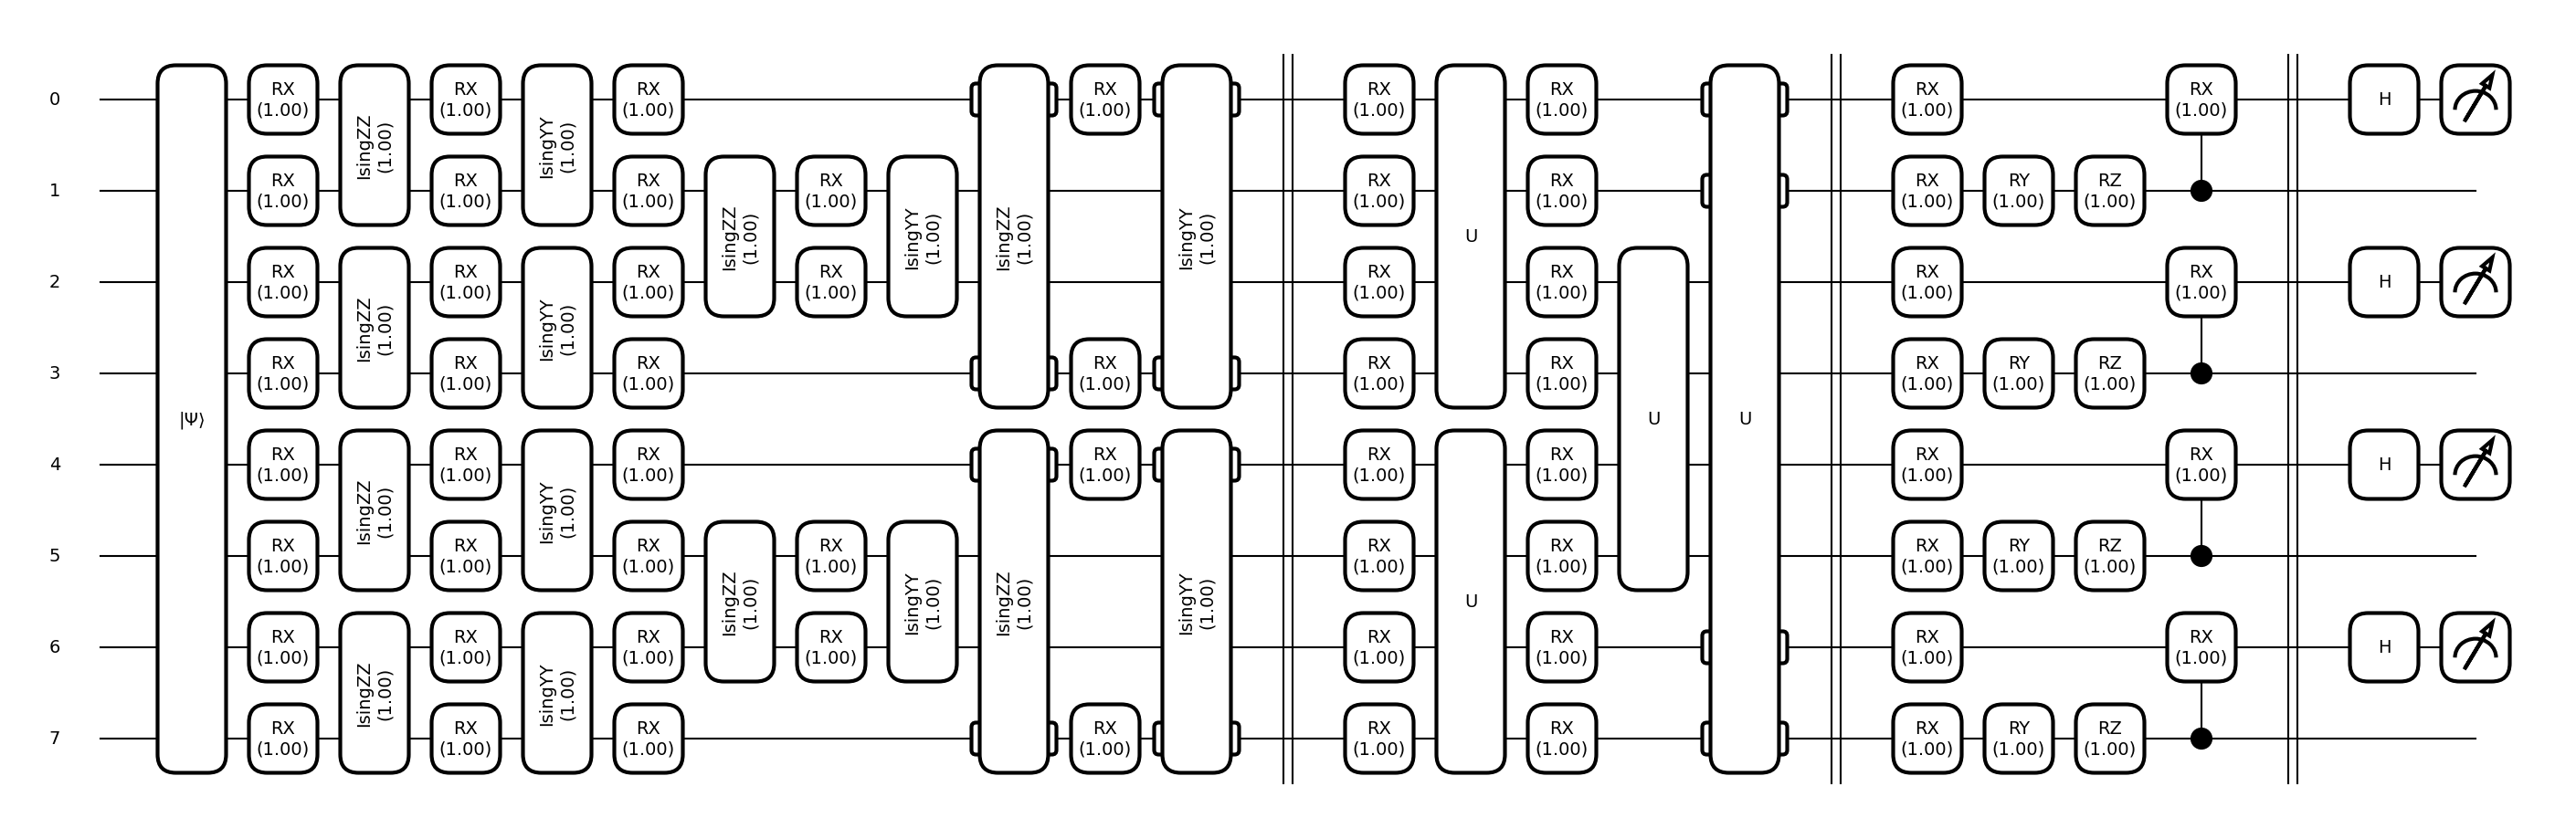

In [81]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

params = jnp.ones(93)
matrix = jnp.array(X_train[0])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)

@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier(X, params, trans_inv = True):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7], trans_inv)
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires = [0,2]), qml.probs(wires = [4,6])
    #return qml.expval(qml.PauliZ(0) @ qml.PauliZ(2) @ qml.PauliZ(4) @ qml.PauliZ(6))

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        qml.Hadamard(0)
        qml.Hadamard(2)
        qml.Hadamard(4)
        qml.Hadamard(6)
        return qml.probs(wires = [0,2]), qml.probs(wires = [4,6])

    return qml.draw_mpl(temp_circuit, decimals = 2)()

# Draw the circuit
draw_circuit(matrix, params)

 Output with Probabilities for Original Image: (Array([0.28643882, 0.22501993, 0.2541747 , 0.23436645], dtype=float32), Array([0.2815119 , 0.21222858, 0.27058074, 0.23567876], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.28643894, 0.22501984, 0.2541746 , 0.23436648], dtype=float32), Array([0.28151178, 0.21222854, 0.2705807 , 0.23567872], dtype=float32))
 Output with Probabilities for Image Reflected over X-axis: (Array([0.28643882, 0.2250199 , 0.25417474, 0.2343665 ], dtype=float32), Array([0.2815119 , 0.21222861, 0.27058074, 0.23567879], dtype=float32))
 Output with Probabilities for Image Rotated 90 Degrees: (Array([0.28151184, 0.2122285 , 0.2705807 , 0.23567876], dtype=float32), Array([0.28643885, 0.22501987, 0.25417462, 0.2343665 ], dtype=float32))


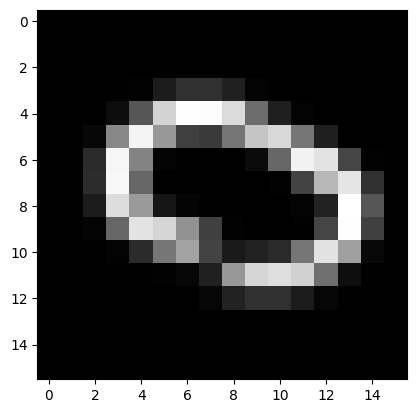

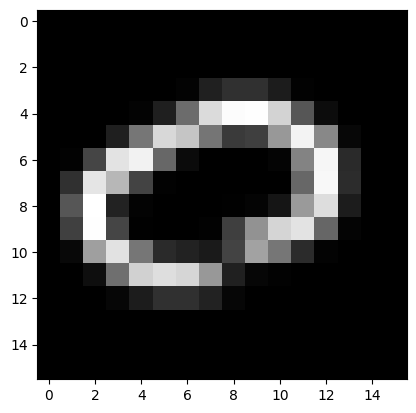

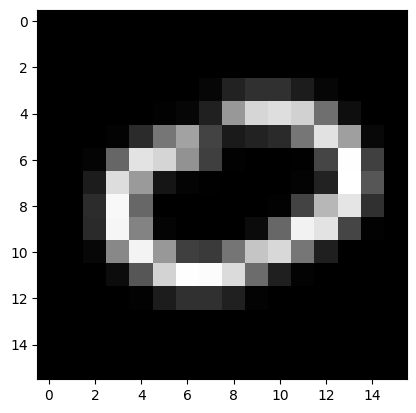

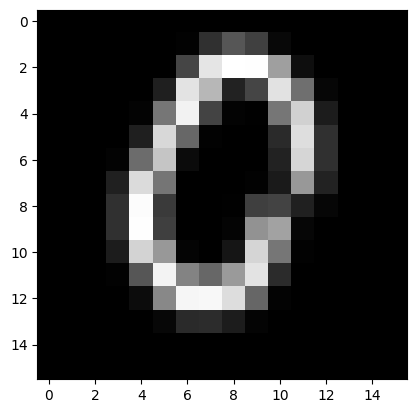

In [69]:
import matplotlib.pyplot as plt

matrix = jnp.array(X_train[7])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier(matrix, params)
result2 = EQNN_classifier(matrix_reflected_y_jax, params)
result3 = EQNN_classifier(matrix_reflected_x_jax, params)
result4 = EQNN_classifier(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.imshow(matrix, cmap='gray')
plt.show()
plt.imshow(matrix_reflected_y, cmap='gray')
plt.show()
plt.imshow(matrix_reflected_x, cmap='gray')
plt.show()
plt.imshow(matrix_rotated_90, cmap='gray')
plt.show()

## 2 measurements

The EQNN with only two measurements has shown that is invariant under the reflexion symmetry over the data. Nevertheless, It presents a slight difference if we apply a rotated by 90 degrees operation over the data.

(<Figure size 3400x900 with 1 Axes>, <Axes: >)

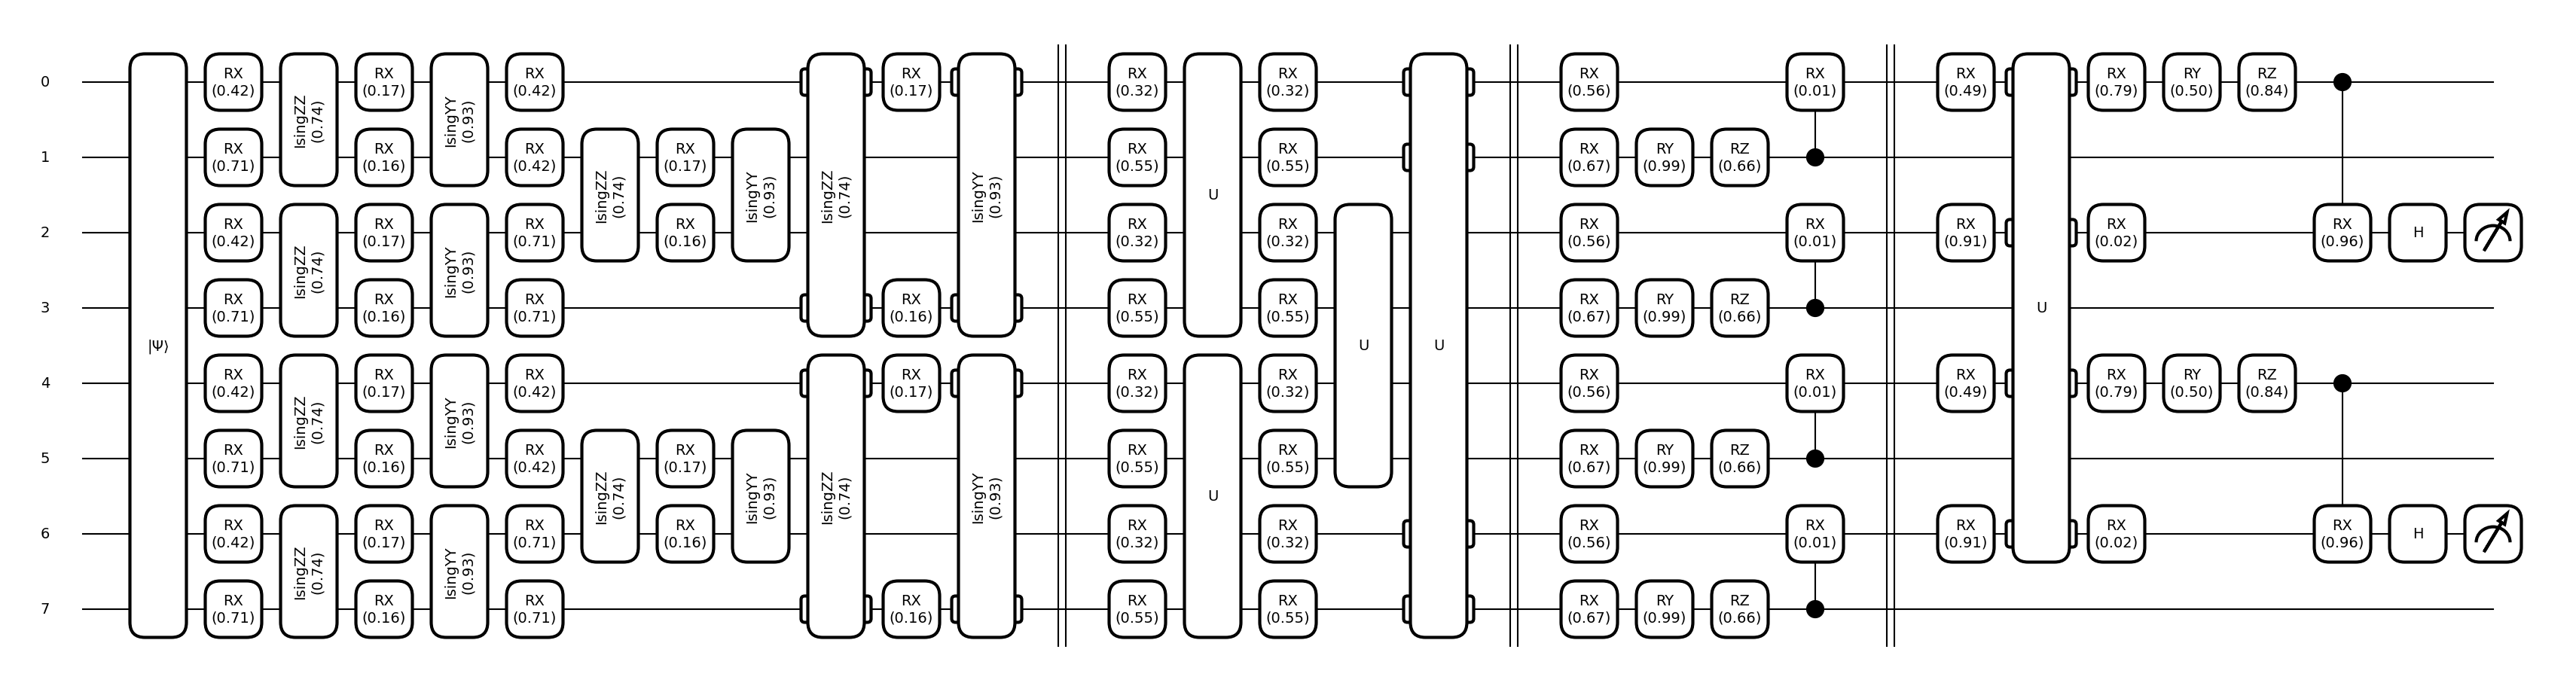

In [80]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

params = jnp.array(np.random.random(22))
matrix = jnp.array(X_train[1])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)


@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier_2m(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    U4(params[14:17], wires = [0,2,4,6])
    Pooling_ansatz(params[17:22], [2,0])
    Pooling_ansatz(params[17:22], [6,4])
    qml.Hadamard(2)
    qml.Hadamard(6)
    #return qml.probs(wires = [2]), qml.probs(wires = [6])
    return qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        U4(params_np[14:17], wires = [0,2,4,6])
        Pooling_ansatz(params_np[17:22], [2,0])
        Pooling_ansatz(params_np[17:22], [6,4])
        qml.Hadamard(2)
        qml.Hadamard(6)
        #return qml.probs(wires = [2]), qml.probs(wires = [6])
        return qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))

    return qml.draw_mpl(temp_circuit, decimals = 2)()

draw_circuit(matrix, params)


In [73]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier_2m(matrix, params)
result2 = EQNN_classifier_2m(matrix_reflected_y_jax, params)
result3 = EQNN_classifier_2m(matrix_reflected_x_jax, params)
result4 = EQNN_classifier_2m(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

 Output with Probabilities for Original Image: 0.04051594436168671
 Output with Probabilities for Image Reflected over Y-axis: 0.04051603376865387
 Output with Probabilities for Image Reflected over X-axis: 0.040516048669815063
 Output with Probabilities for Image Rotated 90 Degrees: 0.04051598906517029


In both models we have seen that the outputs mantains the same value with a high similarity for the original image, the reflected image over X and Y axis and the rotated image by 90 degrees. Then, we can say that this model is invariant under these symmetry operations.

Now, we have to train the latter model.

## Training

In [51]:
jitcircuit = jax.jit(EQNN_classifier_2m)
vcircuit = jax.vmap(jitcircuit, (None, 0), 0)

def map_loss(params, batch):
    loss = 0
    for i in batch:
        f = jitcircuit(i,params)
        loss += (1 - f) ** 2
    return loss / len(batch)

In [75]:
data = jnp.array(np.random.rand(16,16,1))

map_loss(params, jnp.array([data, data*2]))

Array(0.9644251, dtype=float32)

In [29]:
# Generates minibatches only for X
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

hyperparameters

In [53]:
learning_rate = 0.01
epochs = 10
batch_size = 50

In [36]:
optimizer = optax.adam(learning_rate)

initializations of the trainable parameters and the optimizer

In [76]:
weight_shapes = {"weights": (22,)}
key1 = jax.random.PRNGKey(0)
params = jax.random.uniform(key=key1, shape=weight_shapes["weights"])

In [77]:
opt_state = optimizer.init(params)

In [78]:
import time
start = time.time()

hist_loss = []
hist_val_loss = []

for it in range(epochs):
    start_b = time.time()
    for j, Xbatch in enumerate(iterate_minibatches(X_train[:500], batch_size=batch_size)):
        grads = jax.grad(map_loss)(params, Xbatch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        print(j, end="\r")
        if j % 10 == 0:
            end_b = time.time()
            loss = map_loss(params, Xbatch)
            print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 10 :.3}")
            start_b = time.time()

    loss = map_loss(params,X_train[:100])
    hist_loss.append(loss)
    val_loss = map_loss(params, X_test[:100])
    hist_val_loss.append(val_loss)
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss {val_loss:.3}")
    print("____")

val_loss_final = map_loss(params, X_test[:100])
print("final val loss", val_loss_final)

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Step: 0 | Loss: 0.796 | avg step time 0.268
____
Epoch: 0 | Loss: 0.467 | Val Loss 0.475
____
Step: 0 | Loss: 0.44 | avg step time 0.162
____
Epoch: 1 | Loss: 0.268 | Val Loss 0.284
____
Step: 0 | Loss: 0.263 | avg step time 0.3
____
Epoch: 2 | Loss: 0.211 | Val Loss 0.23
____
Step: 0 | Loss: 0.212 | avg step time 0.223
____
Epoch: 3 | Loss: 0.181 | Val Loss 0.2
____
Step: 0 | Loss: 0.183 | avg step time 0.219
____
Epoch: 4 | Loss: 0.163 | Val Loss 0.185
____
Step: 0 | Loss: 0.167 | avg step time 0.267
____
Epoch: 5 | Loss: 0.155 | Val Loss 0.178
____
Step: 0 | Loss: 0.16 | avg step time 0.229
____
Epoch: 6 | Loss: 0.15 | Val Loss 0.173
____
Step: 0 | Loss: 0.155 | avg step time 0.169
____
Epoch: 7 | Loss: 0.146 | Val Loss 0.169
____
Step: 0 | Loss: 0.151 | avg step time 0.223
____
Epoch: 8 | Loss: 0.143 | Val Loss 0.166
____
Step: 0 | Loss: 0.148 | avg step time 0.292
____
Epoch: 9 | Loss: 0.141 | Val Loss 0.163
____
final val loss 0.16263068
Time for 10 epochs: 223.92775964736938


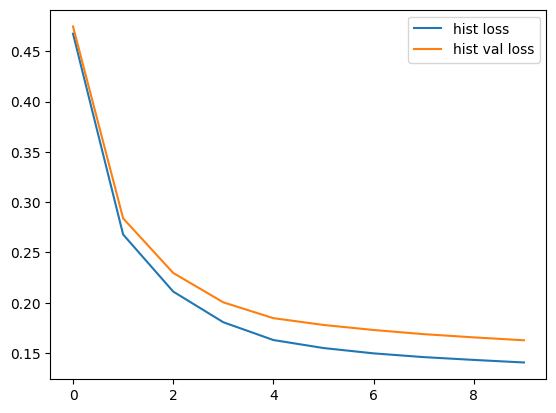

In [79]:
plt.plot(hist_loss, label = "hist loss")
plt.plot(hist_val_loss, label = "hist val loss")
plt.legend()
plt.show()